# Part 2: Model Training, Evaluation & Artifact Generation


## 2.1 Setup, Imports & Configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso;
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
import time
import warnings; import gc;
import shap


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
plt.style.use('seaborn-v0_8-whitegrid')

%matplotlib inline

MODEL_DIR = 'saved_models'
STATIC_FOLDER = 'static'
PLOTS_SUBFOLDER = 'plots'
PLOTS_DIR = os.path.join(STATIC_FOLDER, PLOTS_SUBFOLDER)
TOP_N_FEATURES = 25
CLEANED_DATA_CSV_PATH = './data/df_cleaned_for_modeling.csv'
CLEANED_DATA_ARTIFACTS_PATH = os.path.join(MODEL_DIR, 'data_processing_artifacts.joblib')

os.makedirs(MODEL_DIR,exist_ok=True)
os.makedirs(PLOTS_DIR,exist_ok=True)
print("Part 2 Setup complete.")

Part 2 Setup complete.


## 2.2 Load Cleaned Data and Artifacts from Part 1

In [3]:
print("--- Loading Cleaned Data and Artifacts from Part 1 ---")
try:
    df_cleaned = pd.read_csv(CLEANED_DATA_CSV_PATH)
    print(f"Loaded df_cleaned from CSV, shape: {df_cleaned.shape}")
    part1_artifacts = joblib.load(CLEANED_DATA_ARTIFACTS_PATH)
    numeric_features = part1_artifacts.get('numeric_features_for_model', [])
    categorical_features = part1_artifacts.get('categorical_features_for_model', [])
    expected_columns_before_preprocessing = part1_artifacts.get('expected_columns_for_model', []) 
    available_zips_clean = part1_artifacts.get('available_zips_clean', []) 
    available_fips_clean = part1_artifacts.get('available_fips_clean', [])
    default_suggestions = part1_artifacts.get('default_suggestions', {}) 
    field_descriptions = part1_artifacts.get('field_descriptions', {})
    id_value_mappings = part1_artifacts.get('id_value_mappings', {})

    print(f"Loaded Part 1 artifacts: {len(numeric_features)} numeric, {len(categorical_features)} categorical model features identified.")
    
    if 'regionidzip' in categorical_features: 
        print("'regionidzip' IS in categorical_features and will be OHE'd.")
    else:
        print("CRITICAL WARNING: 'regionidzip' NOT found in categorical_features from Part 1 artifacts! Check Part 1 logic.")
    if 'fips' in categorical_features:
        print("'fips' IS in categorical_features and will be OHE'd.")
    else:
        print("CRITICAL WARNING: 'fips' NOT found in categorical_features from Part 1 artifacts! Check Part 1 logic.")
except Exception as e:
    print(f"ERROR loading Part 1 data/artifacts: {e}");
    raise e

# Ensure features intended as categorical for the model are string type before preprocessor
for col in categorical_features:
    if col in df_cleaned.columns and df_cleaned[col].dtype != 'object' and df_cleaned[col].dtype != pd.StringDtype():
        df_cleaned[col] = df_cleaned[col].astype(str)

display(df_cleaned.head(2))

--- Loading Cleaned Data and Artifacts from Part 1 ---
Loaded df_cleaned from CSV, shape: (161247, 22)
Loaded Part 1 artifacts: 11 numeric, 10 categorical model features identified.
'regionidzip' IS in categorical_features and will be OHE'd.
'fips' IS in categorical_features and will be OHE'd.


,year,airconditioningtypeid,architecturalstyletypeid,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidzip,roomcnt,storytypeid,typeconstructiontypeid,unitcnt,saleprice,building_age
0,2016,Central,Unknown,2.0,3.0,Unknown,4.0,2.0,1684.0,1684.0,6037.0,2.0,Central,7528.0,Single Family Residential,96370.0,0.0,Unknown,Unknown,1.0,350365.236140,57.0
1,2016,Unknown,Unknown,3.5,4.0,Unknown,NaN,3.5,2263.0,2263.0,6059.0,3.0,Unknown,3643.0,Single Family Residential,96962.0,0.0,Unknown,Unknown,NaN,692920.803591,2.0


## 2.3 EDA on Loaded Cleaned Data (Optional)

Generating correlation heatmaps...


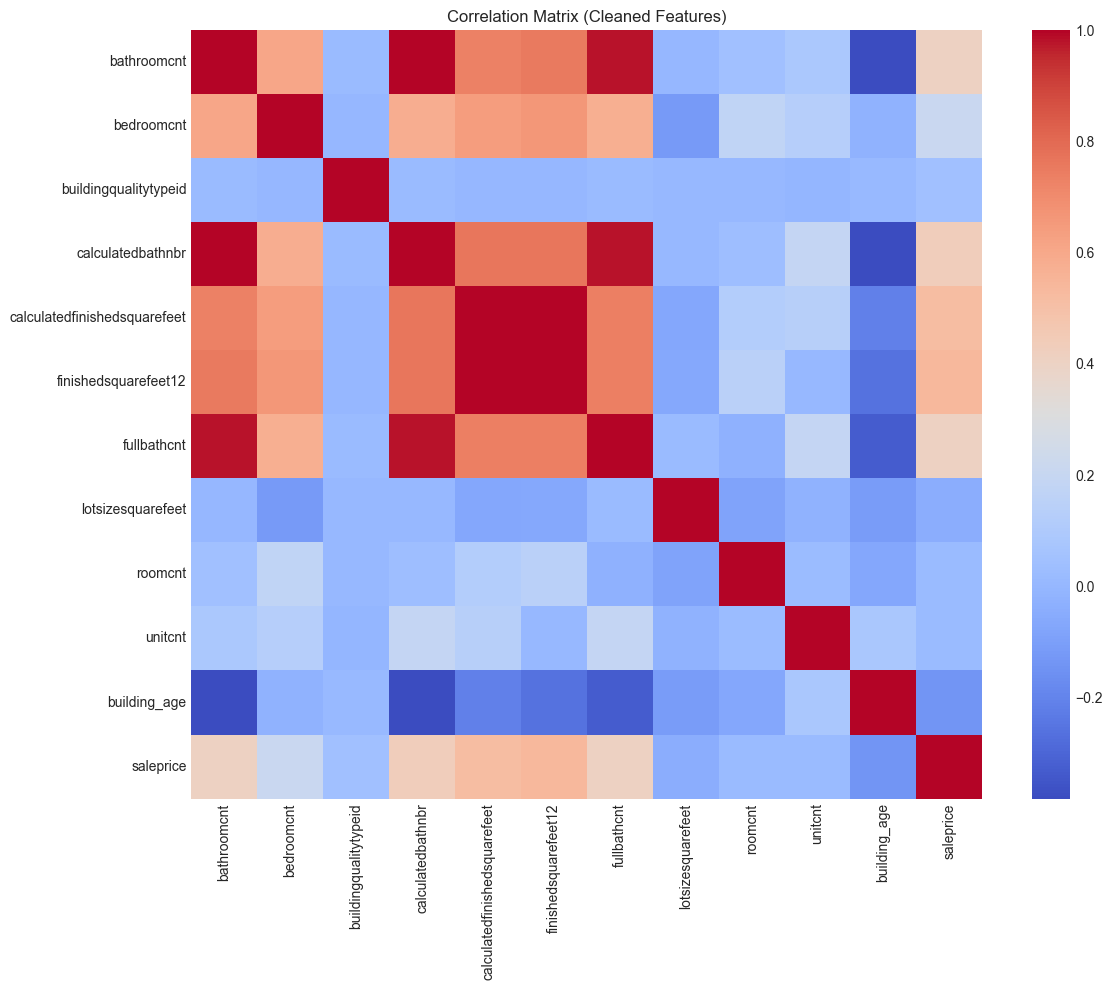

- Correlation heatmap (cleaned) saved.
- Clustered heatmap saved.
Generating price by ZIP plot...


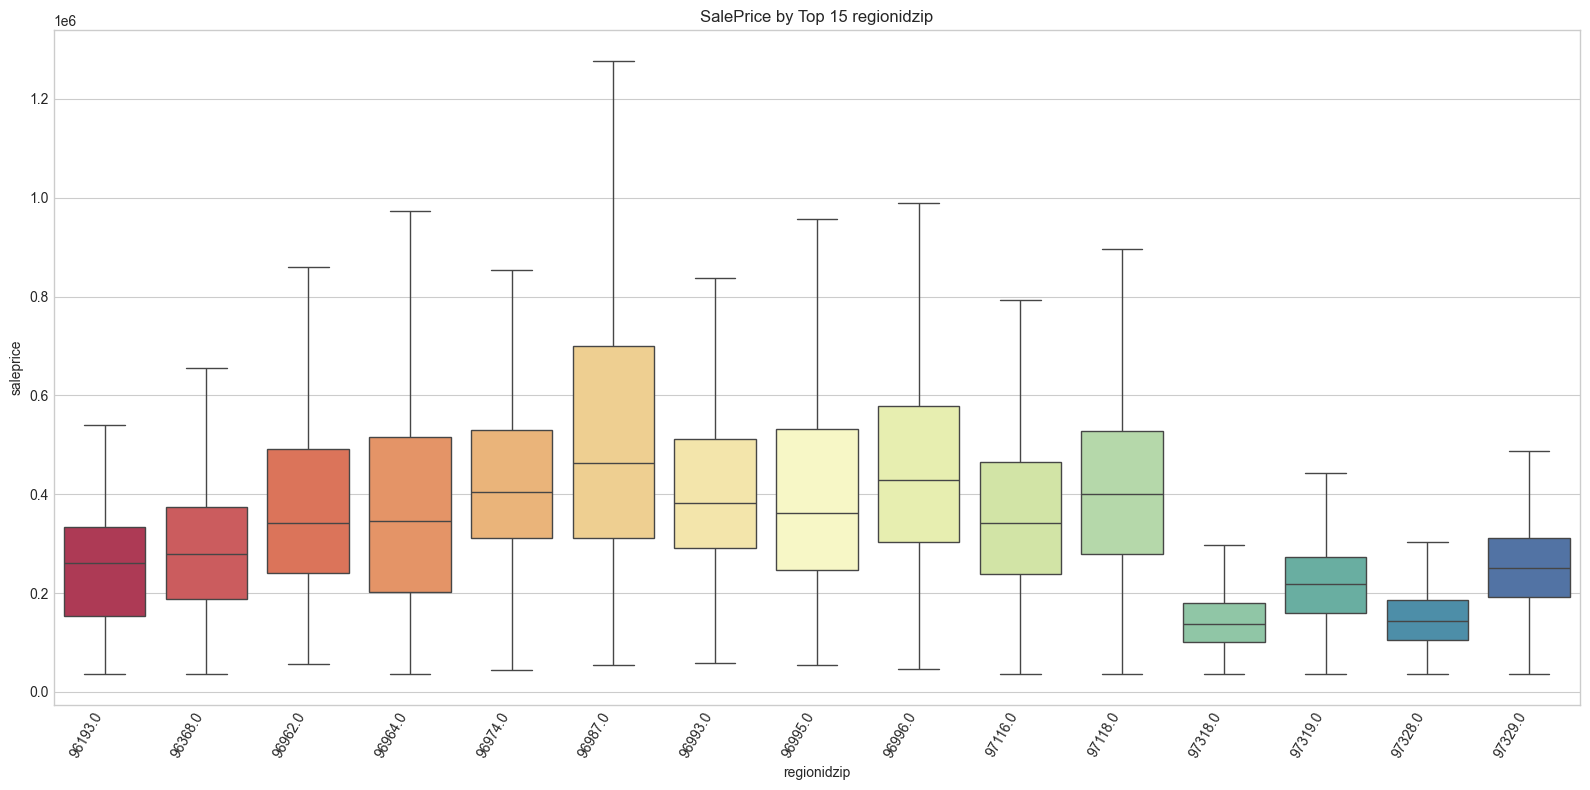

- Price by ZIP plot saved.
--- EDA on Loaded Data (Example: SqFt vs Price) ---
- EDA plot saved: static\plots\sqft_vs_price_sample_eda_part2.png


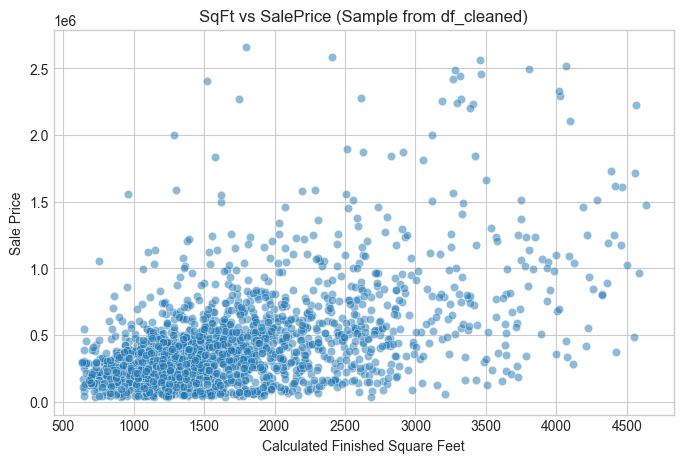

Generating price plots...


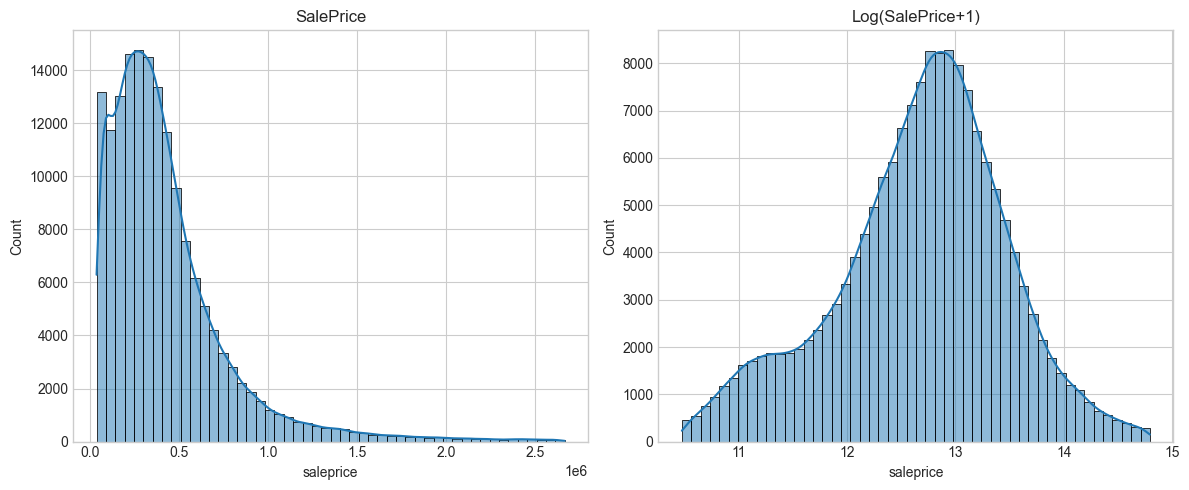

- Price distribution plot saved.


In [ ]:


eda_numeric_features_final = [col for col in numeric_features if col in df_cleaned.columns]

# General Correlation
print("Generating correlation heatmaps...")
if len(eda_numeric_features_final) > 1 and 'saleprice' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['saleprice']):
    correlation_matrix_cleaned = df_cleaned[eda_numeric_features_final + ['saleprice']].corr()
    plt.figure(figsize=(max(12, len(eda_numeric_features_final)*0.6), max(10, len(eda_numeric_features_final)*0.5)))
    sns.heatmap(correlation_matrix_cleaned, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix (Cleaned Features)')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(PLOTS_DIR, 'correlation_matrix_cleaned_standard.png'))
    plt.close()
    print("- Correlation heatmap (cleaned) saved.")
    if 'saleprice' in correlation_matrix_cleaned:
         n_top = min(30, len(eda_numeric_features_final)); 
         if n_top > 1:
             top_feats = correlation_matrix_cleaned['saleprice'].abs().sort_values(ascending=False).head(n_top + 1).index.tolist(); clust_mat = df_cleaned[top_feats].corr()
             try: c_fig = sns.clustermap(clust_mat,annot=True,fmt=".2f",cmap='coolwarm',figsize=(min(16,len(top_feats)*0.6),min(14,len(top_feats)*0.5)));c_fig.ax_heatmap.set_title(f'Clustered Corr (Top {n_top})');plt.setp(c_fig.ax_heatmap.get_xticklabels(),rotation=45,ha='right');plt.savefig(os.path.join(PLOTS_DIR,'correlation_matrix_clustered.png'));plt.close(c_fig.fig);print("- Clustered heatmap saved.")
             except Exception as e: print(f'Warn: Clustered heatmap failed: {e}')
else: print("- Skipping correlation analysis.")

# Price by ZIP
print("Generating price by ZIP plot...")
if 'regionidzip' in df_cleaned.columns and 'regionidzip' in categorical_features and 'saleprice' in df_cleaned.columns:
    df_cleaned['regionidzip'] = df_cleaned['regionidzip'].astype(str) # Ensure it's string for EDA
    zip_col = 'regionidzip'
    if df_cleaned[zip_col].nunique() > 1:
        n_zips = min(15, df_cleaned[zip_col].nunique()); top_zips = df_cleaned[zip_col].value_counts().nlargest(n_zips).index.tolist()
        if top_zips:
            df_top = df_cleaned[df_cleaned[zip_col].isin(top_zips)]
            plt.figure(figsize=(16, 8)); 
            sns.boxplot(data=df_top, x=zip_col, y='saleprice', order=sorted(top_zips), showfliers=False, palette='Spectral')
            plt.title(f'SalePrice by Top {len(top_zips)} regionidzip')
            plt.xticks(rotation=60, ha='right'); plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(PLOTS_DIR,'saleprice_by_regionidzip_cleaned.png'))
            plt.close(); print("- Price by ZIP plot saved.")
else: print("- Skipping price by ZIP plot.")

print("--- EDA on Loaded Data (Example: SqFt vs Price) ---")
if 'calculatedfinishedsquarefeet' in df_cleaned.columns and 'saleprice' in df_cleaned.columns:
    sample_eda = df_cleaned.sample(min(2000, len(df_cleaned)), random_state=1)
    plt.figure(figsize=(8,5)); sns.scatterplot(data=sample_eda, x='calculatedfinishedsquarefeet', y='saleprice', alpha=0.5)
    plt.title('SqFt vs SalePrice (Sample from df_cleaned)'); plt.xlabel('Calculated Finished Square Feet'); plt.ylabel('Sale Price');
    eda_plot_path = os.path.join(PLOTS_DIR, 'sqft_vs_price_sample_eda_part2.png')
    try: plt.savefig(eda_plot_path); print(f"- EDA plot saved: {eda_plot_path}")
    except Exception as e: print(f"Error saving EDA plot: {e}")
    plt.show(); plt.close()
else: print("Skipping SqFt vs Price EDA (required columns not found).")

print("Generating price plots...")
if 'saleprice' in df_cleaned.columns:
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  sns.histplot(df_cleaned['saleprice'],bins=50,kde=True)
  plt.title('SalePrice')
  plt.subplot(1,2,2)
  sns.histplot(np.log1p(df_cleaned['saleprice']),bins=50,kde=True)
  plt.title('Log(SalePrice+1)')
  plt.tight_layout()
  plt.savefig(os.path.join(PLOTS_DIR,'saleprice_distribution.png'))
  plt.show()
  plt.close()
  print("- Price distribution plot saved.")
  gc.collect()

## 2.4 Preprocessing Pipeline Definition

In [9]:
print("--- Defining Preprocessing Pipeline ---")
numeric_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])
transformers_list = []
if numeric_features:
    transformers_list.append(('num', numeric_transformer, numeric_features))
if categorical_features:
    transformers_list.append(('cat', categorical_transformer, categorical_features))

preprocessor = None
if transformers_list:
    preprocessor=ColumnTransformer(transformers=transformers_list,remainder='drop',verbose_feature_names_out=False)
    print("Preprocessor defined. It will use specified numeric/categorical features (incl. 'regionidzip', 'fips') and drop others.")
    from sklearn import set_config; set_config(display='diagram'); display(preprocessor)
else: 
    print("ERROR: No numeric or categorical features specified for the preprocessor! Cannot proceed.")

--- Defining Preprocessing Pipeline ---
Preprocessor defined. It will use specified numeric/categorical features (incl. 'regionidzip', 'fips') and drop others.


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['bathroomcnt', 'bedroomcnt',
                                  'buildingqualitytypeid', 'calculatedbathnbr',
                                  'calculatedfinishedsquarefeet',
                                  'finishedsquarefeet12', 'fullbathcnt',
                                  'lotsizesquarefeet', 'roomcnt', 'unitcnt',
                                  'building_age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airconditioningtypeid',
                                  'architecturalstyletypeid',
                                  'buildingclasstypeid',
                                  'heatingorsystemtypeid',
                                  'propertylandusetypeid', 'regionidzip',
                                  'storytypeid', 'typeconstructiontypeid',
                                  'year', 'fips'])],
                  verbose_feature_names_out=False)

## 2.5 Final Data Preparation for Modeling (Splitting & Fitting Preprocessor)

In [10]:
print("--- Final Data Prep for Modeling ---")
assert 'df_cleaned' in locals() and not df_cleaned.empty, "df_cleaned missing or empty!"
assert preprocessor is not None, "Preprocessor not defined!"
assert 'saleprice' in df_cleaned.columns, "Target 'saleprice' missing in df_cleaned!"

X = df_cleaned[expected_columns_before_preprocessing].copy() 
y = df_cleaned['saleprice'].copy()
print(f"Shape of X for splitting (from df_cleaned using expected_columns): {X.shape}")
if 'regionidzip' in X.columns and 'regionidzip' in categorical_features: print("'regionidzip' IS in X and categorical_features, will be OHE'd by preprocessor.")
if 'fips' in X.columns and 'fips' in categorical_features: print("'fips' IS in X and categorical_features, will be OHE'd by preprocessor.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Fitting preprocessor & transforming data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Processed train data shape: {X_train_processed.shape}, Processed test data shape: {X_test_processed.shape}")

final_model_input_feature_names = None;
try:
    num_tf_obj = preprocessor.named_transformers_.get('num')
    actual_numeric_feats_to_num_tf = list(preprocessor.transformers_[0][2]) if num_tf_obj and preprocessor.transformers_ and preprocessor.transformers_[0][0]=='num' else []
    cat_tf_obj = preprocessor.named_transformers_.get('cat')
    cat_transformer_idx = next((i for i,t in enumerate(preprocessor.transformers_) if t[0]=='cat'), -1)
    actual_categorical_feats_to_cat_tf = []
    ohe_feature_names = []
    if cat_tf_obj and cat_transformer_idx != -1:
        actual_categorical_feats_to_cat_tf = list(preprocessor.transformers_[cat_transformer_idx][2])
        ohe_step_in_cat_pipeline = cat_tf_obj.named_steps.get('onehot')
        if ohe_step_in_cat_pipeline and hasattr(ohe_step_in_cat_pipeline,'get_feature_names_out') and actual_categorical_feats_to_cat_tf:
            ohe_feature_names = list(ohe_step_in_cat_pipeline.get_feature_names_out(actual_categorical_feats_to_cat_tf))
    final_model_input_feature_names = list(actual_numeric_feats_to_num_tf) + ohe_feature_names
    if final_model_input_feature_names and len(final_model_input_feature_names) == X_train_processed.shape[1]:
        print(f"Successfully extracted {len(final_model_input_feature_names)} final model input feature names after preprocessing.")
    else: raise ValueError(f"Feature name count mismatch. Expected {X_train_processed.shape[1]}, got {len(final_model_input_feature_names if final_model_input_feature_names else [])}")
except Exception as e:
    print(f"Warning: Detailed feature name extraction failed: {e}. Using generic names.")
    final_model_input_feature_names = [f'model_feature_{i}' for i in range(X_train_processed.shape[1])]

joblib.dump(preprocessor, os.path.join(MODEL_DIR, 'preprocessor_fitted_part2.joblib')); print("- Fitted Preprocessor (from Part 2) saved.")
joblib.dump(final_model_input_feature_names or [], os.path.join(MODEL_DIR, 'feature_names_final_model_inputs.joblib')); print("- Final model input feature names (post-preprocessing) saved.")

del X, y, X_train, X_test, df_cleaned; gc.collect()

--- Final Data Prep for Modeling ---
Shape of X for splitting (from df_cleaned using expected_columns): (161247, 21)
'regionidzip' IS in X and categorical_features, will be OHE'd by preprocessor.
'fips' IS in X and categorical_features, will be OHE'd by preprocessor.
Fitting preprocessor & transforming data...
Processed train data shape: (128997, 453), Processed test data shape: (32250, 453)
Successfully extracted 453 final model input feature names after preprocessing.
- Fitted Preprocessor (from Part 2) saved.
- Final model input feature names (post-preprocessing) saved.


20734

## 2.6 Model Building (LightGBM default)

In [11]:
print("--- Defining Models ---")
models = {
    "Ridge": Ridge(alpha=5.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=10, n_jobs=-1, random_state=42, max_features=0.6),
    "LightGBM": lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=-1, importance_type='gain', verbosity=-1)
}
ENABLE_STACKING = True
if ENABLE_STACKING:
    estimators_stack = [
        ('ridge', Ridge(alpha=5.0, random_state=42)), 
        ('rf', RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=10, n_jobs=-1, random_state=42, max_features=0.6)), 
        ('lgbm', lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=-1, importance_type='gain', verbosity=-1))
    ]
    stacking_model = StackingRegressor(estimators=estimators_stack, final_estimator=RidgeCV(alphas=np.logspace(-2,2,10)), cv=3, n_jobs=-1)
    models["Stacked Ensemble (LGBM)"] = stacking_model
print(f"Models to train: {list(models.keys())}")

--- Defining Models ---
Models to train: ['Ridge', 'Random Forest', 'LightGBM', 'Stacked Ensemble (LGBM)']


## 2.7 Model Evaluation

--- Model Training and Evaluation ---

Training Ridge...
-> Ridge: Test RMSE:249,300, R2:0.4794 | Train RMSE:246,544 | Time: 1.08s

Training Random Forest...
-> Random Forest: Test RMSE:256,999, R2:0.4468 | Train RMSE:236,567 | Time: 469.10s

Training LightGBM...
-> LightGBM: Test RMSE:241,614, R2:0.5110 | Train RMSE:230,925 | Time: 3.61s

Training Stacked Ensemble (LGBM)...
-> Stacked Ensemble (LGBM): Test RMSE:734,180,628, R2:-4514919.7616 | Train RMSE:735,878,203 | Time: 1653.77s

--- Model Performance Summary ---


,RMSE_Test,MAE_Test,R2_Test,RMSE_Train,Time (s)
LightGBM,2.416143e+05,1.636344e+05,5.110218e-01,2.309252e+05,3.610498
Ridge,2.493005e+05,1.695827e+05,4.794163e-01,2.465442e+05,1.076954
Random Forest,2.569985e+05,1.725628e+05,4.467703e-01,2.365671e+05,469.096328
Stacked Ensemble (LGBM),7.341806e+08,5.432375e+08,-4.514920e+06,7.358782e+08,1653.767464


- Performance plot saved: static\plots\model_performance_comparison_part2.png.


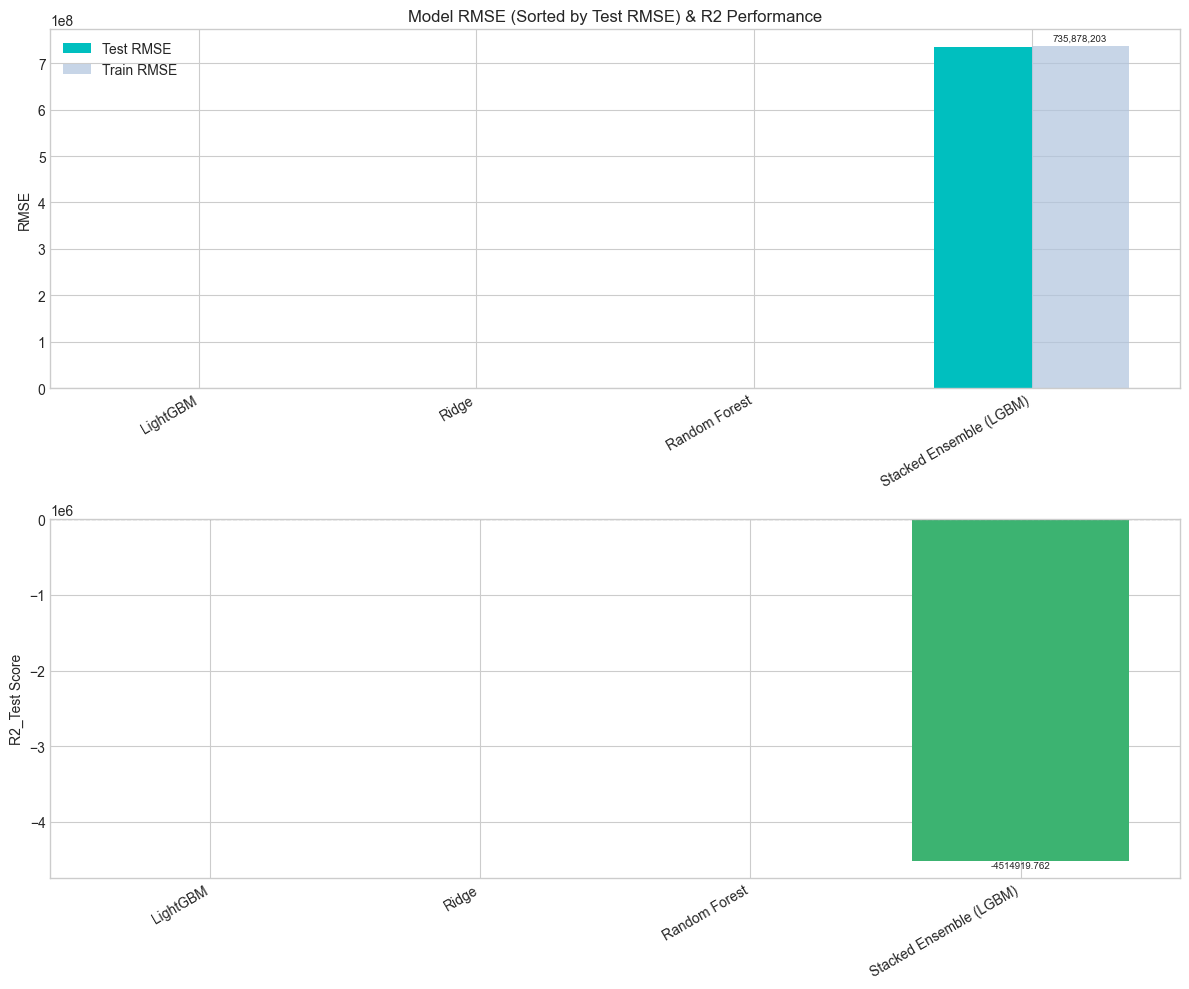

In [12]:
print("--- Model Training and Evaluation ---")
results = {}; trained_models = {}
assert 'X_train_processed' in locals() and 'X_test_processed' in locals(), "Processed data missing!"
assert 'y_train' in locals() and 'y_test' in locals(), "Target variable missing!"
for name, model_obj in models.items():
    start_time=time.time();print(f"\nTraining {name}...")
    model_obj.fit(X_train_processed,y_train);trained_models[name]=model_obj
    y_pred_test=model_obj.predict(X_test_processed)
    y_pred_train=model_obj.predict(X_train_processed)
    rmse_t=np.sqrt(mean_squared_error(y_test,y_pred_test))
    mae_t=mean_absolute_error(y_test,y_pred_test)
    r2_t=r2_score(y_test,y_pred_test)
    rmse_tr=np.sqrt(mean_squared_error(y_train,y_pred_train))
    results[name]={'RMSE_Test':rmse_t,'MAE_Test':mae_t,'R2_Test':r2_t,'RMSE_Train':rmse_tr,'Time (s)':time.time()-start_time}
    print(f"-> {name}: Test RMSE:{rmse_t:,.0f}, R2:{r2_t:.4f} | Train RMSE:{rmse_tr:,.0f} | Time: {results[name]['Time (s)']:.2f}s")
results_df = pd.DataFrame(results).T.sort_values(by='RMSE_Test')
print("\n--- Model Performance Summary ---");display(results_df)
if not results_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid'); 
    fig,axes=plt.subplots(2,1,figsize=(12,10),sharex=False)
    idx=np.arange(len(results_df))
    bw=0.35
    axes[0].bar(idx-bw/2,results_df['RMSE_Test'],bw,label='Test RMSE',color='c')
    axes[0].bar(idx+bw/2,results_df['RMSE_Train'],bw,label='Train RMSE',color='lightsteelblue',alpha=0.7)
    axes[0].set_ylabel('RMSE'); axes[0].set_title('Model RMSE (Sorted by Test RMSE) & R2 Performance')
    axes[0].legend(); axes[0].set_xticks(idx); axes[0].set_xticklabels(results_df.index,rotation=30,ha='right')
    for i, rect in enumerate(axes[0].patches): height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., height + 0.01*height, f'{height:,.0f}', ha='center', va='bottom', fontsize=7)
    r2_df_sorted=results_df.sort_values('R2_Test',ascending=False); r2_indices = np.arange(len(r2_df_sorted))
    axes[1].bar(r2_indices,r2_df_sorted['R2_Test'],color='mediumseagreen')
    axes[1].set_ylabel('R2_Test Score')
    axes[1].axhline(0,color='k',lw=0.8,ls='--')
    axes[1].set_xticks(r2_indices)
    axes[1].set_xticklabels(r2_df_sorted.index,rotation=30,ha='right')
    for i, rect in enumerate(axes[1].patches): height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width()/2., height + (0.01 if height >=0 else -0.05) , f'{height:.3f}', ha='center', va='bottom' if height >=0 else 'top', fontsize=7)
    plt.tight_layout()
    perf_plot_path = os.path.join(PLOTS_DIR,'model_performance_comparison_part2.png')
    try:
        plt.savefig(perf_plot_path); print(f'- Performance plot saved: {perf_plot_path}.')
    except Exception as e:
        print(f"Error saving performance plot: {e}")
    plt.show()
    plt.close()

## 2.8 Feature Importance & SHAP Analysis

--- Feature Importance & SHAP Analysis ---
Best model selected: LightGBM
Extracted 453 importance values from the model.
Created DataFrame of processed feature importances (model's direct inputs like 'fips_value').
Created DataFrame of aggregated feature importances (summing OHE columns to original names like 'fips').
- Field order preference generated from aggregated importances (18 features).
- UI feature importance table data (from aggregated importances) generated.
- Aggregated importance plot (showing 'fips', 'regionidzip') saved: static\plots\feature_importance_aggregated_original_part2.png


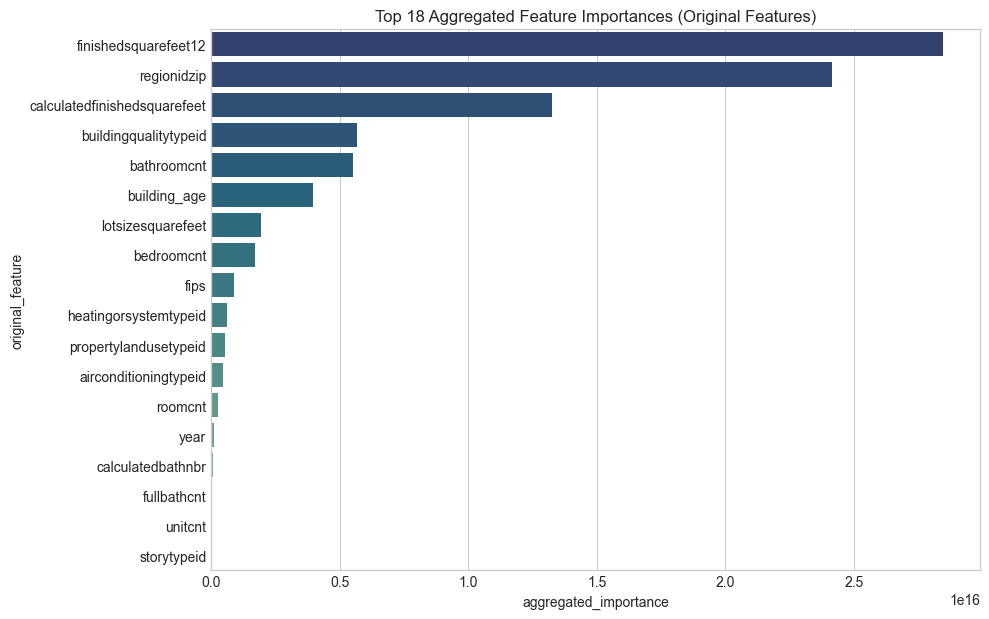

- Processed importance plot (showing OHE columns like 'fips_value') saved: static\plots\feature_importance_processed_part2.png


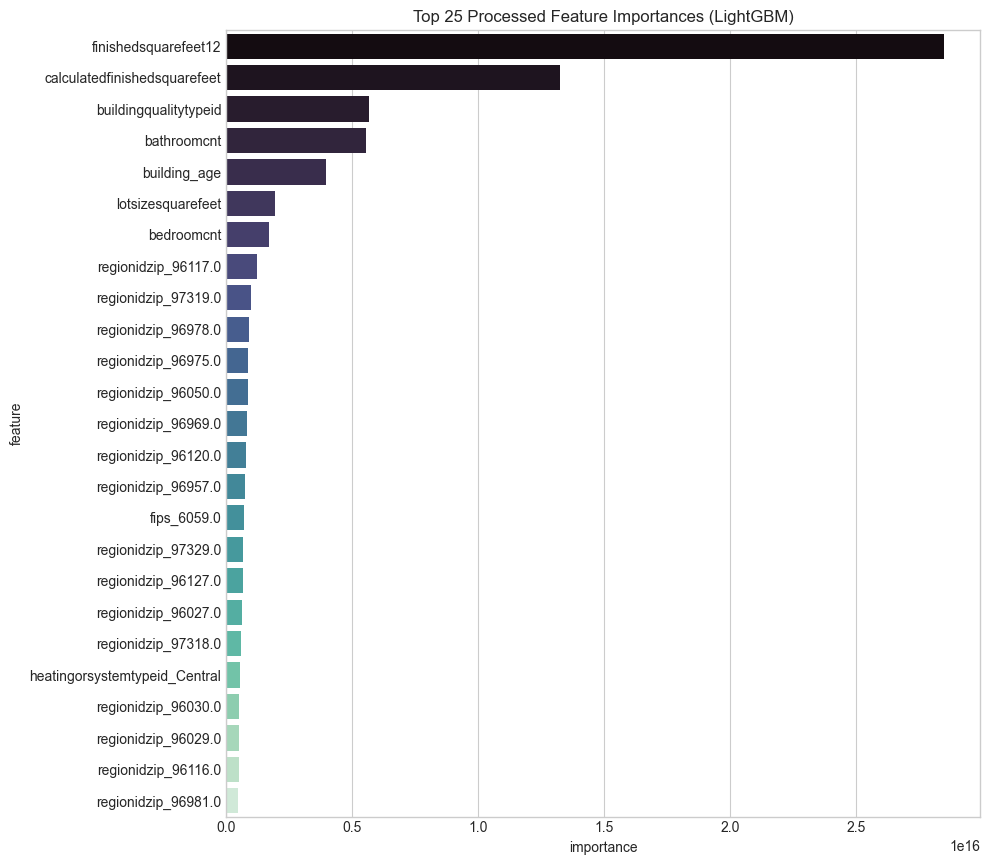


--- SHAP Analysis Attempt ---
SHAP for LightGBM (sample size: 500)...
- SHAP bar: static\plots\shap_summary_bar_part2.png


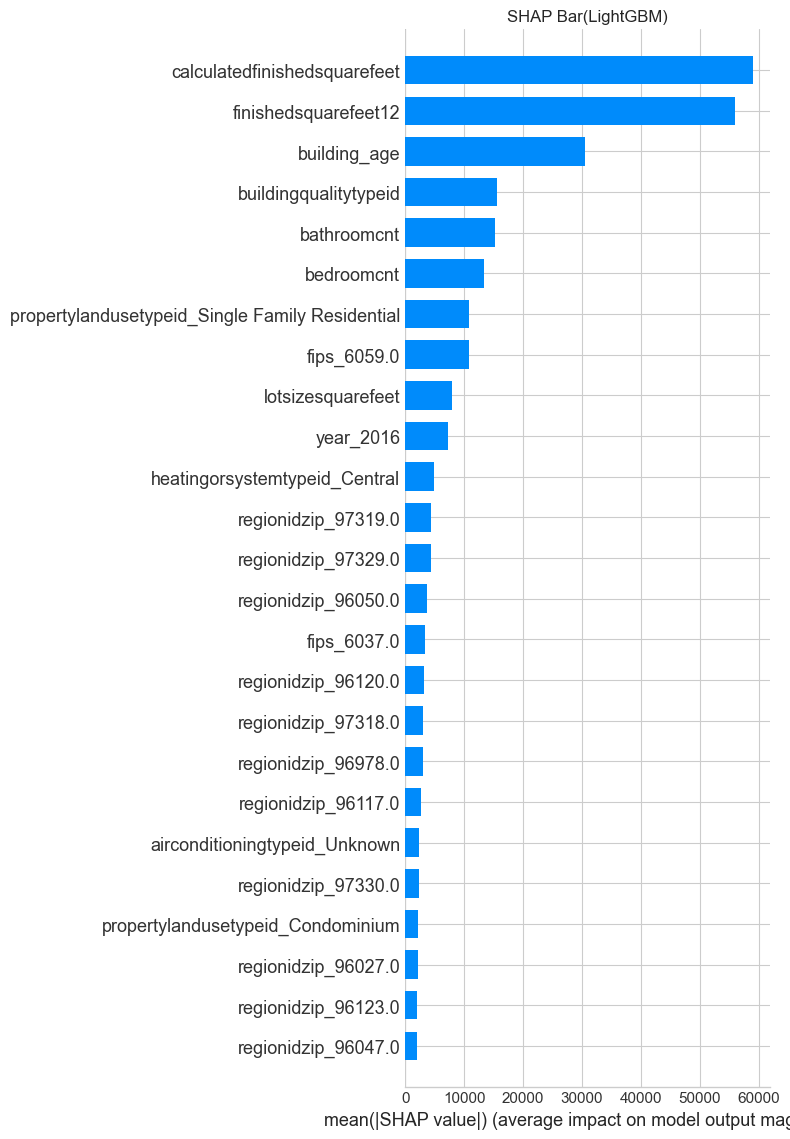

- SHAP dot: static\plots\shap_summary_dots_part2.png


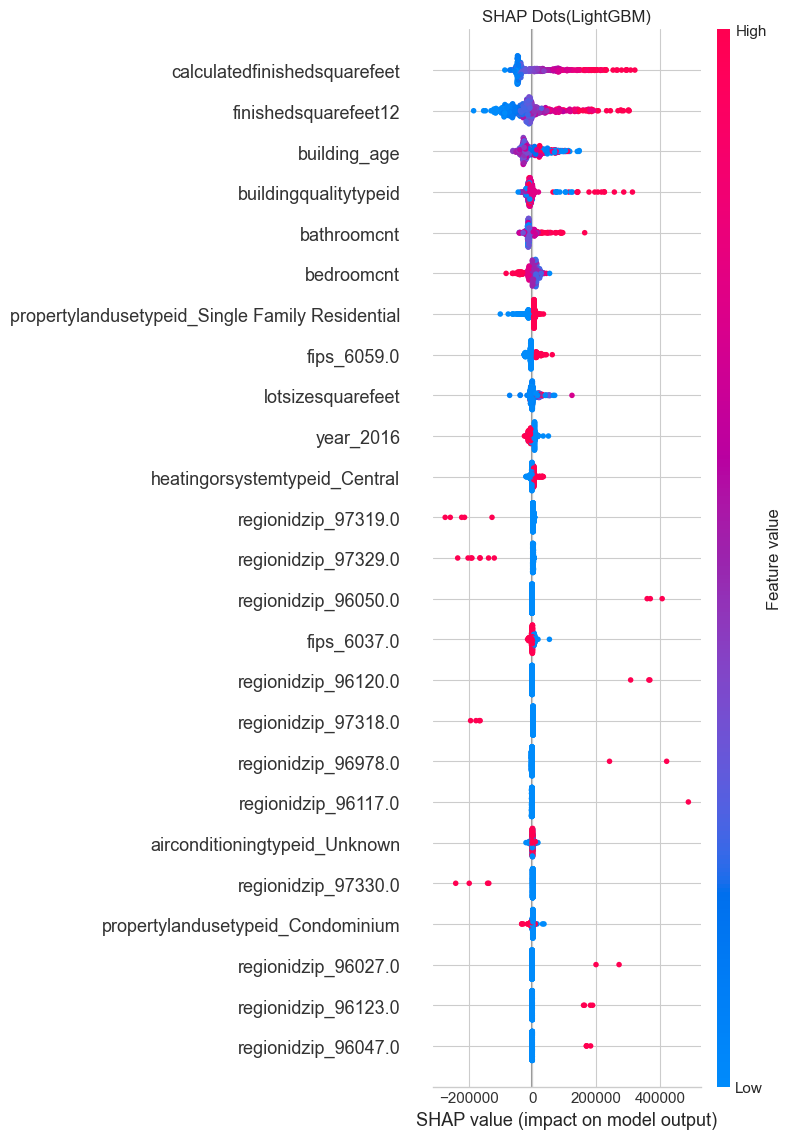

21008

In [13]:
print("--- Feature Importance & SHAP Analysis ---")
best_model_name=None; final_model_object=None; importances_processed=None; 
feature_importance_df_processed=None; aggregated_importance_df=None; feature_importance_data_for_ui_table=None
field_order_preference_from_importance = list(expected_columns_before_preprocessing if 'expected_columns_before_preprocessing' in locals() else [])
top_n_display = TOP_N_FEATURES

if 'results_df' in locals() and not results_df.empty: best_model_name=results_df['RMSE_Test'].dropna().idxmin(); final_model_object=trained_models.get(best_model_name); print(f"Best model selected: {best_model_name}")

if final_model_object:
    try: 
        if hasattr(final_model_object,'feature_importances_'): importances_processed = final_model_object.feature_importances_
        elif isinstance(final_model_object,StackingRegressor): 
            if hasattr(final_model_object.final_estimator_, 'coef_'): importances_processed = np.abs(final_model_object.final_estimator_.coef_.squeeze())
            else: lgbm_base=final_model_object.named_estimators_.get('lgbm'); rf_base=final_model_object.named_estimators_.get('rf')
            if lgbm_base and hasattr(lgbm_base,'feature_importances_'):importances_processed=lgbm_base.feature_importances_;print("- Stack: LGBM base importance.")
            elif rf_base and hasattr(rf_base,'feature_importances_'):importances_processed=rf_base.feature_importances_;print("- Stack: RF base importance.")
        elif hasattr(final_model_object,'coef_'): importances_processed = np.abs(final_model_object.coef_.squeeze())
        if importances_processed is not None: print(f"Extracted {len(importances_processed)} importance values from the model.")
    except Exception as e:print(f"Error extracting importances: {e}")

if 'final_model_input_feature_names' not in locals() or not final_model_input_feature_names: print("ERROR: 'final_model_input_feature_names' missing!"); importances_processed=None

if importances_processed is not None and final_model_input_feature_names and len(importances_processed)==len(final_model_input_feature_names):
    feature_importance_df_processed=pd.DataFrame({'feature':final_model_input_feature_names,'importance':importances_processed}).sort_values('importance',ascending=False)
    print("Created DataFrame of processed feature importances (model's direct inputs like 'fips_value').")
    if not feature_importance_df_processed.empty:
        aggregated_importances_map={}
        original_numeric_features_for_agg = locals().get('numeric_features', []) 
        original_categorical_features_for_agg = locals().get('categorical_features', []) 
        for orig_feat_name in original_numeric_features_for_agg:
            if orig_feat_name in feature_importance_df_processed['feature'].values: aggregated_importances_map[orig_feat_name] = feature_importance_df_processed.loc[feature_importance_df_processed['feature'] == orig_feat_name, 'importance'].sum()
        for orig_cat_feat_name in original_categorical_features_for_agg: # This loop includes 'regionidzip', 'fips'
            ohe_cols_for_this_cat_feat = [proc_feat_name for proc_feat_name in final_model_input_feature_names if proc_feat_name.startswith(orig_cat_feat_name + "_")]
            if not ohe_cols_for_this_cat_feat and orig_cat_feat_name in final_model_input_feature_names: ohe_cols_for_this_cat_feat = [orig_cat_feat_name]
            current_sum = feature_importance_df_processed[feature_importance_df_processed['feature'].isin(ohe_cols_for_this_cat_feat)]['importance'].sum()
            if current_sum > 1e-9: aggregated_importances_map[orig_cat_feat_name] = aggregated_importances_map.get(orig_cat_feat_name, 0) + current_sum
        if aggregated_importances_map:
            aggregated_importance_df=pd.DataFrame(list(aggregated_importances_map.items()),columns=['original_feature','aggregated_importance']).sort_values('aggregated_importance',ascending=False)
            print("Created DataFrame of aggregated feature importances (summing OHE columns to original names like 'fips').")
            if not aggregated_importance_df.empty:
                field_order_preference_from_importance=aggregated_importance_df['original_feature'].tolist()
                print(f"- Field order preference generated from aggregated importances ({len(field_order_preference_from_importance)} features).")
                feature_importance_data_for_ui_table = aggregated_importance_df.head(top_n_display).rename(columns={'original_feature': 'feature', 'aggregated_importance': 'importance'}).to_dict(orient='records')
                print(f"- UI feature importance table data (from aggregated importances) generated.")
else: print(f"Warning: Importance array length ({len(importances_processed if importances_processed is not None else [])}) and feature names length ({len(final_model_input_feature_names if final_model_input_feature_names else [])}) mismatch or one is missing.")

if not field_order_preference_from_importance: field_order_preference_from_importance = list(expected_columns_before_preprocessing if 'expected_columns_before_preprocessing' in locals() else [])
if feature_importance_data_for_ui_table is None: feature_importance_data_for_ui_table=[]

if aggregated_importance_df is not None and not aggregated_importance_df.empty:
    try: top_n=min(top_n_display,len(aggregated_importance_df)); plt.figure(figsize=(10,max(6,top_n*0.35))); sns.barplot(x='aggregated_importance',y='original_feature',data=aggregated_importance_df.head(top_n),palette='crest_r');plt.title(f'Top {top_n} Aggregated Feature Importances (Original Features)');plt.tight_layout();path=os.path.join(PLOTS_DIR,'feature_importance_aggregated_original_part2.png');plt.savefig(path);print(f"- Aggregated importance plot (showing 'fips', 'regionidzip') saved: {path}");plt.show()
    except Exception as e:print(f"ERROR plotting aggregated importances: {e}")
    finally:plt.close()
else: print("Skipping aggregated importance plot (data unavailable).")

if feature_importance_df_processed is not None and not feature_importance_df_processed.empty:
    try: top_n=min(top_n_display,len(feature_importance_df_processed));plt.figure(figsize=(10,max(6,top_n*0.35)));sns.barplot(x='importance',y='feature',data=feature_importance_df_processed.head(top_n),palette='mako');plt.title(f'Top {top_n} Processed Feature Importances ({best_model_name or 'Model'})');plt.tight_layout();path=os.path.join(PLOTS_DIR,'feature_importance_processed_part2.png');plt.savefig(path);print(f"- Processed importance plot (showing OHE columns like 'fips_value') saved: {path}");plt.show()
    except Exception as e:print(f"ERROR plotting processed importances: {e}")
    finally:plt.close()
else: print("Skipping processed importance plot (data unavailable).")

print("\n--- SHAP Analysis Attempt ---")
if shap and best_model_name and final_model_object and 'X_train_processed' in locals() and X_train_processed.shape[0]>0 and 'final_model_input_feature_names' in locals() and final_model_input_feature_names:
    try:
        X_train_processed_df_for_shap = pd.DataFrame(X_train_processed, columns=final_model_input_feature_names);
        sample_size_shap = min(500, X_train_processed_df_for_shap.shape[0])
        if sample_size_shap > 0:
            X_shap_sample_df = shap.sample(X_train_processed_df_for_shap, sample_size_shap, random_state=42)
            print(f"SHAP for {best_model_name} (sample size: {sample_size_shap})...");explainer_obj=None;shap_values_output=None;model_for_shap_explanation=final_model_object;shap_model_display_name=best_model_name
            if isinstance(final_model_object,StackingRegressor):
                lgbm_s=final_model_object.named_estimators_.get('lgbm')
                rf_s=final_model_object.named_estimators_.get('rf')
                if lgbm_s and hasattr(lgbm_s,'predict'):model_for_shap_explanation=lgbm_s;shap_model_display_name=f"{best_model_name}(LGBM Base)";print("- Stack:SHAP(LGBM Base)")
                elif rf_s and hasattr(rf_s,'predict'):model_for_shap_explanation=rf_s;shap_model_display_name=f"{best_model_name}(RF Base)";print("- Stack:SHAP(RF Base)")
            
            if isinstance(model_for_shap_explanation,(RandomForestRegressor,GradientBoostingRegressor,lgb.LGBMRegressor)):
                explainer_obj=shap.TreeExplainer(model_for_shap_explanation)
            elif isinstance(model_for_shap_explanation,(LinearRegression,Ridge,Lasso,RidgeCV)):
                explainer_obj=shap.LinearExplainer(model_for_shap_explanation,X_shap_sample_df)
            
            if explainer_obj:shap_values_output=explainer_obj.shap_values(X_shap_sample_df)
            
            if shap_values_output is not None:
                try:
                    shap.summary_plot(shap_values_output,X_shap_sample_df,plot_type="bar",max_display=top_n_display,show=False)
                    plt.title(f"SHAP Bar({shap_model_display_name})");plt.tight_layout();path=os.path.join(PLOTS_DIR,'shap_summary_bar_part2.png')
                    plt.savefig(path);print(f"- SHAP bar: {path}");plt.show();plt.close()
                except Exception as e:print(f"ERR SHAP bar:{e}");plt.close()
                try:
                    shap.summary_plot(shap_values_output,X_shap_sample_df,max_display=top_n_display,show=False)
                    plt.title(f"SHAP Dots({shap_model_display_name})");plt.tight_layout();path=os.path.join(PLOTS_DIR,'shap_summary_dots_part2.png')
                    plt.savefig(path);print(f"- SHAP dot: {path}");plt.show();plt.close()
                except Exception as e:print(f"ERR SHAP dot:{e}");plt.close()
    except Exception as e:print(f"Error SHAP:{e}")
else:print("Skipping SHAP.")
gc.collect()

## 2.9 Save Final Artifacts for Flask App

In [14]:
print("--- Step 2.9: Saving Final Artifacts for Flask App ---")
joblib.dump(locals().get('id_value_mappings', {}), os.path.join(MODEL_DIR, 'id_value_mappings_final.joblib'))
print("- ID-to-Value mappings saved.")
joblib.dump(locals().get('field_descriptions', {}), os.path.join(MODEL_DIR, 'field_descriptions_final.joblib'))
print("- Field descriptions saved.")
joblib.dump(feature_importance_data_for_ui_table or [], os.path.join(MODEL_DIR, 'feature_importance_table_data_final.joblib'))
print(f"- Feature importance table data (aggregated for UI) saved ({len(feature_importance_data_for_ui_table or [])} items).")
joblib.dump(field_order_preference_from_importance or [], os.path.join(MODEL_DIR, 'field_order_preference_final.joblib'))
print(f"- Field order preference list (aggregated for UI) saved ({len(field_order_preference_from_importance or [])} items).")
joblib.dump(locals().get('default_suggestions', {}), os.path.join(MODEL_DIR, 'default_suggestions_final.joblib'))
print("- Default value suggestions for UI saved.")
joblib.dump(locals().get('available_zips_clean', []), os.path.join(MODEL_DIR, 'available_zips_clean_final.joblib'))
print("- Available ZIPs for UI saved.")
joblib.dump(locals().get('available_fips_clean', []), os.path.join(MODEL_DIR, 'available_fips_clean_final.joblib'))
print("- Available FIPS codes for UI saved.")
joblib.dump(locals().get('numeric_features', []), os.path.join(MODEL_DIR, 'numeric_features_for_preprocessor_final.joblib'))
print("- Original numeric features list (for preprocessor) saved.")
joblib.dump(locals().get('categorical_features', []), os.path.join(MODEL_DIR, 'categorical_features_for_preprocessor_final.joblib'))
print("- Original categorical features list (for preprocessor, incl. 'regionidzip', 'fips') saved.")
joblib.dump(locals().get('expected_columns_before_preprocessing', []), os.path.join(MODEL_DIR, 'expected_columns_before_preprocessing_final.joblib'))
print("- List of all raw input columns (before preprocessor) saved.")

if os.path.exists(os.path.join(MODEL_DIR, 'preprocessor_fitted_part2.joblib')): print("- Fitted preprocessor already saved.")
if os.path.exists(os.path.join(MODEL_DIR, 'feature_names_final_model_inputs.joblib')): print("- Final model input feature names (post-OHE) already saved.")

if best_model_name and final_model_object:
    final_model_filename = f'{best_model_name.replace(" ", "_").lower()}_final_model_v_part2.joblib'
    final_model_path = os.path.join(MODEL_DIR, final_model_filename)
    try: joblib.dump(final_model_object, final_model_path); print(f"- Best Model '{best_model_name}' saved to {final_model_path}")
    except Exception as e: print(f"ERROR saving final model: {e}")
else: print("Warning: Skipping best model saving.")

print("\n--- All Final Artifact Saving Complete (Part 2) ---")
print("--- PROCESS COMPLETED ---")

--- Step 2.9: Saving Final Artifacts for Flask App ---
- ID-to-Value mappings saved.
- Field descriptions saved.
- Feature importance table data (aggregated for UI) saved (18 items).
- Field order preference list (aggregated for UI) saved (18 items).
- Default value suggestions for UI saved.
- Available ZIPs for UI saved.
- Available FIPS codes for UI saved.
- Original numeric features list (for preprocessor) saved.
- Original categorical features list (for preprocessor, incl. 'regionidzip', 'fips') saved.
- List of all raw input columns (before preprocessor) saved.
- Fitted preprocessor already saved.
- Final model input feature names (post-OHE) already saved.
- Best Model 'LightGBM' saved to saved_models\lightgbm_final_model_v_part2.joblib

--- All Final Artifact Saving Complete (Part 2) ---
--- PROCESS COMPLETED ---
